# Eye-Blink Detection
This notebook is an exploratory analysis of some preliminary data for the 2021-2022 blink-controlled car project (clever name pending). This is our testing space for trying out different analysis approaches.

## Preliminary Data
The following uses data on normal and driving-type blinks recorded on November 11 2021, by Matthew Blacker, Michael Kim, and Alex Pleava, from Matthew Blacker.
The data consists of three files:
1. **Blinks_60s_BlinkEvery5s.csv**: Data on normal blinks, roughly every 5 seconds for 60 seconds (minus stream initiation time)
2. **DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s.csv**: Data on left-eye driving blinks, roughly every 10 seconds for 120 seconds (minus stream initiation time).
3. **DrivingBlinksRightEye_120s_BlinkEvery10sFor2s.csv**: Data on right-eye driving blinks, roughly every 10 seconds for 120 seconds (minus stream initiation time).

Our goals for the analysis are:
1. Detect normal eyeblinks
2. Detect normal eyeblinks from only the first 0.5 seconds of a blink
3. Separate normal eyeblinks from driving eye blinks
4. Detect which eye the eyeblinks are coming from

### Loading in the Data and Preparing the Dataset
We want to load in the data and prepare it to be analyzed. To do this, we'll store the actual values in pandas dataframes, which are python data structures that resemble spreadsheets, and are frequently used to store lots of tabular data. These dataframes really store the actual data inside a numpy array.

Once we have the data, we'll want to load it into MNE, by using it to initialize a RawData object in MNE.

Finally, we want to separate the eyeblinks so that we know which stretches of time contain eyeblinks, and which don't.

In [1]:
# Load in the data as pandas dataframes
import pandas as pd
# Keep a dictionary so we can index each dataset by name
raw_recordings = {"Normal_Blinks": pd.read_csv("Blinks_60s_BlinkEvery5s.csv"), 
                "Driving_Left": pd.read_csv("DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s.csv"), 
                "Driving_Right": pd.read_csv("DrivingBlinksRightEye_120s_BlinkEvery10sFor2s.csv")}
# Print the head of the dataframes so we can verify that it imported properly
for key in raw_recordings.keys():
    print(raw_recordings[key].head())

   timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1635968532   3.418  36.621  33.691  24.902     61.035
1  1635968532 -18.066  36.621  32.227  30.273     67.871
2  1635968532  32.227  31.250  31.250  25.879     94.238
3  1635968532  88.867  30.273  31.738  15.137    110.352
4  1635968532  27.832  31.738  35.645  16.602     94.727
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.635970e+09  83.984  25.391  26.367  13.184     48.340
1  1.635970e+09  39.551  20.508  27.832  17.578     52.246
2  1.635970e+09 -17.578  13.184  35.645  17.578     34.180
3  1.635970e+09  -6.348  14.648  30.273  16.602     40.527
4  1.635970e+09  55.176  17.090  15.137  14.648     48.828
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.635969e+09  69.824  39.551  38.086  40.039    104.492
1  1.635969e+09  93.750  35.156  26.367  27.832     18.066
2  1.635969e+09  -5.371  32.227  40.527  27.344     -9.766
3  1.635969e+09 -28.809  36.621  44.922  27.344    -15.137
4  1.6359

Now, we want to separate the timepans that correspond to individual eyeblinks. We can try using the fact that eyeblinks tend to have voltages that dip below -100, and typically last about 200 timepoints. Let's see how well that works.

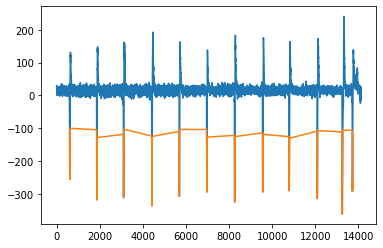

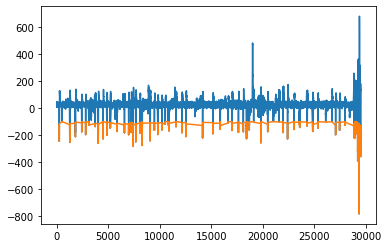

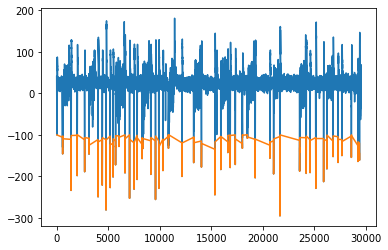

In [2]:
# Import matplotlib.pytplot for plotting
import matplotlib.pyplot as plt
# Import for manipulating arrays
import numpy as np

# The start and stop indices of the first blink for each dataset
eyeblink_discrimination_voltage = -100
eyeblink_discrimination_channel = "TP10"

# For each dataset, locate the eyeblinks
for key, dataset in raw_recordings.items():
    blink_locations = np.where(dataset[eyeblink_discrimination_channel] < eyeblink_discrimination_voltage)
    plt.plot(dataset[eyeblink_discrimination_channel])
    plt.plot(dataset[eyeblink_discrimination_channel][blink_locations[0]])
    plt.show()

It looks like this method correctly finds the eyeblinks, shown as the orange high-lighted segments. 

Although this appears to be a perfect way to detect eyeblinks, our job is not done. It's not ideal since it's very dependent on the specific channel you use. Try changing the `channel` variable above to see what I mean. I manually went through the different channels and found one that worked. Also, this method doesn't distinguish between normal and driving blinks.

Nevertheless, we can use it to separate our data into blink and non-blink epochs.

In [3]:
# For each dataset, locate the eyeblinks
for key, dataset in raw_recordings.items():
    # Get the locations where the voltage dips below the discrimination voltage
    blink_locations = np.where(dataset[eyeblink_discrimination_channel] < eyeblink_discrimination_voltage)[0]
    # Create a new array, which is the blink_locations abvoe shifted over by one position
    shifted_blink_positions = np.roll(blink_locations, 1)
    # Subtract the shifted array from the original one; the locations where this is != 1 are where
    # the ranges in the array above are not continuous. ex. [4, 5, 6, 104, 105, 106] - [106, 4, 5, 6, 104, 105] = [-102, 1, 1, 98, 1, 1]
    blink_locations = blink_locations[(blink_locations - shifted_blink_positions) != 1]

    # Create a new column in the dataset which represents whether we currently are in a blink or not
    dataset["Blink"] = np.zeros(dataset["timestamps"].size)
    # On each side of the blink locations, a range from 50 before and 150 after should cover the whole blink
    for blink_location in blink_locations:
        start = blink_location - 50
        stop = blink_location + 150
        if blink_location < 50: start = 0
        if blink_location + 150 > dataset["timestamps"].size: stop = dataset["timestamps"].size
        dataset["Blink"][start:stop] = np.ones(stop - start)

C:\Users\alexp\AppData\Local\Temp/ipykernel_3960/2407428941.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Blink"][start:stop] = np.ones(stop - start)


Now, we can plot the eyeblinks to see if we labelled the data properly with blinks. If you change the left and right variables below you can scan through the data sets and see if we properly detected eyeblinks throughout.

It looks like we did, so now we can count on the "Blink" column of our dataset to tell us whether a particular time point is during a blink or not.

Detected eyeblinks for Normal_Blinks


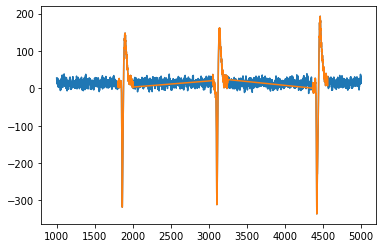

Detected eyeblinks for Driving_Left


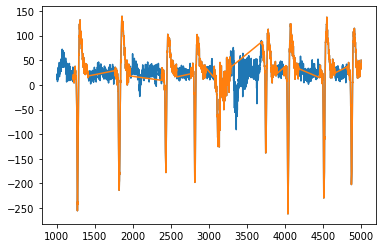

Detected eyeblinks for Driving_Right


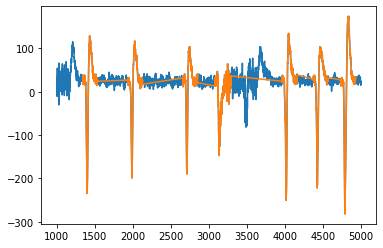

In [4]:
# Set the left and right x-limits of the plot so we can zoom in to specific regions and see if the partitioning is accurate
left = 1000
right = 5000
# Plot the data in this region, and colour the detected eyeblinks orange
for key, dataset in raw_recordings.items():
    print(f"Detected eyeblinks for {key}")
    plt.plot(dataset[eyeblink_discrimination_channel][left:right])
    plt.plot(dataset[eyeblink_discrimination_channel][left:right][dataset["Blink"] == 1])
    plt.show()

Finally, we are ready to create the MNE objects that we'll use for the rest of the analysis:

In [5]:
# Import MNE
import mne
# Create the info object that stores our metadata
info = mne.create_info(["timestamps","TP9","AF7","AF8", "TP10", "Right AUX", "Blink"], 256)
# Create the MNE raw data object using the raw data (.values.T to extract the values only,)
raw_data = {key : mne.io.RawArray(raw_recordings[key].values.T, info) for key, _ in raw_recordings.items()}
# Create the MNE Epochs object using the Blink column
events = {key: mne.find_events(raw_data[key], stim_channel="Blink") for key in raw_recordings}
epoched_data = {key: mne.Epochs(raw_data[key], events[key]) for key in raw_recordings}

Creating RawArray with float64 data, n_channels=7, n_times=14124
    Range : 0 ... 14123 =      0.000 ...    55.168 secs
Ready.
Creating RawArray with float64 data, n_channels=7, n_times=29550
    Range : 0 ... 29549 =      0.000 ...   115.426 secs
Ready.
Creating RawArray with float64 data, n_channels=7, n_times=29517
    Range : 0 ... 29516 =      0.000 ...   115.297 secs
Ready.
12 events found
Event IDs: [1]
53 events found
Event IDs: [1]
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
47 events found
Event IDs: [1]
Not setting metadata
Not setting metadata
12 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
53 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projecti

Lets visualize the epochs and see if we can notice any patterns in the averaged-out eyeblinks

Loading data for 12 events and 180 original time points ...
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


C:\Users\alexp\AppData\Local\Temp/ipykernel_3960/3086511893.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=["TP10"])


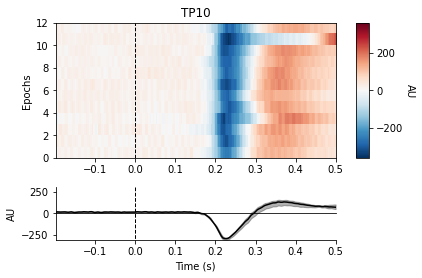

Loading data for 53 events and 180 original time points ...
Not setting metadata
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


C:\Users\alexp\AppData\Local\Temp/ipykernel_3960/3086511893.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=["TP10"])


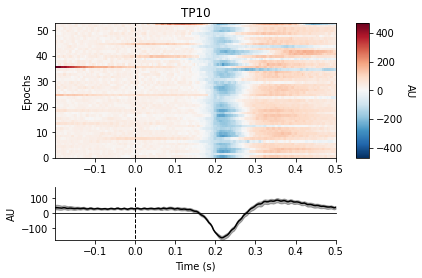

Loading data for 47 events and 180 original time points ...
Not setting metadata
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


C:\Users\alexp\AppData\Local\Temp/ipykernel_3960/3086511893.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=["TP10"])


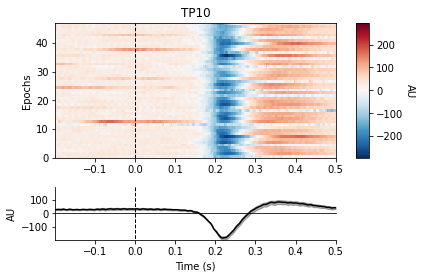

In [8]:
for key, dataset in epoched_data.items():
    dataset.plot_image(picks=["TP10"])

In [ ]:
Ther